In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython.display as ipd
from scipy import signal
from scipy.fft import fft, fftfreq
import io
import urllib.request
from scipy.io import wavfile

from IPython.display import Audio, display

## Loading audio files

In [8]:
def load_audio_from_url(url):
    """Load audio directly from URL without saving to disk"""
    try:
        print(f"Streaming audio from URL...")
        # Download to memory
        with urllib.request.urlopen(url) as response:
            audio_data = response.read()
        
        # Create a file-like object in memory
        audio_file = io.BytesIO(audio_data)
        
        # Read WAV file from memory
        sample_rate, audio_array = wavfile.read(audio_file)
        
        # Convert to mono if stereo
        if len(audio_array.shape) > 1:
            audio_array = audio_array.mean(axis=1)
        
        # Normalize
        audio_array = audio_array.astype(float)
        if np.max(np.abs(audio_array)) > 0:
            audio_array = audio_array / np.max(np.abs(audio_array))
        
        print(f"✓ Loaded audio: {len(audio_array)} samples at {sample_rate} Hz")
        return audio_array, sample_rate
        
    except Exception as e:
        print(f"✗ Failed to load audio: {e}")
        return None, None

# Try to load audio from online source
print("="*70)
print("AUDIO LOADING (NO FILES SAVED)")
print("="*70)

# Try multiple sources
audio_urls = [
    'https://www.kozco.com/tech/organfinale.wav',
    'https://www.kozco.com/tech/piano2.wav',
    'https://freewavesamples.com/files/Alesis-Sanctuary-QCard-Crickets.wav'
]

# Collect multiple audio files
audio_files = []  # List to store (audio_data, sample_rate, url) tuples

for url in audio_urls:
    audio_data, sample_rate = load_audio_from_url(url)
    if audio_data is not None:
        audio_files.append({
            'data': audio_data,
            'sample_rate': sample_rate,
            'url': url,
            'name': url.split('/')[-1]  # Extract filename from URL
        })
        print(f"✓ Added to collection: {url.split('/')[-1]}")

print(f"\n{'='*70}")
print(f"Successfully loaded {len(audio_files)} audio file(s)")
print(f"{'='*70}")

AUDIO LOADING (NO FILES SAVED)
Streaming audio from URL...


/tmp/ipython-input-1564709216.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_array = wavfile.read(audio_file)


✓ Loaded audio: 573378 samples at 44100 Hz
✓ Added to collection: organfinale.wav
Streaming audio from URL...
✓ Loaded audio: 302712 samples at 48000 Hz
✓ Added to collection: piano2.wav
Streaming audio from URL...
✓ Loaded audio: 405562 samples at 44100 Hz
✓ Added to collection: Alesis-Sanctuary-QCard-Crickets.wav

Successfully loaded 3 audio file(s)


In [ ]:
display(Audio(audio_files[0]['data'], rate=audio_files[0]['sample_rate']))

In [12]:
display(Audio(audio_files[1]['data'], rate=audio_files[1]['sample_rate']))

In [13]:
display(Audio(audio_files[2]['data'], rate=audio_files[2]['sample_rate']))

In [15]:
# load audio files with librosa
debussy, sr = audio_files[0]['data'], audio_files[0]['sample_rate']
redhot, _ = audio_files[1]['data'], audio_files[1]['sample_rate']
duke, _ = audio_files[2]['data'], audio_files[2]['sample_rate']

## Basic information regarding audio files

In [16]:
debussy.shape

(573378,)

In [17]:
# duration in seconds of 1 sample
sample_duration = 1 / sr
print(f"One sample lasts for {sample_duration:6f} seconds")

One sample lasts for 0.000023 seconds


In [18]:
# total number of samples in audio file
tot_samples = len(debussy)
tot_samples

573378

In [19]:
# duration of debussy audio in seconds
duration = 1 / sr * tot_samples
print(f"The audio lasts for {duration} seconds")

The audio lasts for 13.001768707482993 seconds


## Visualising audio signal in the time domain 

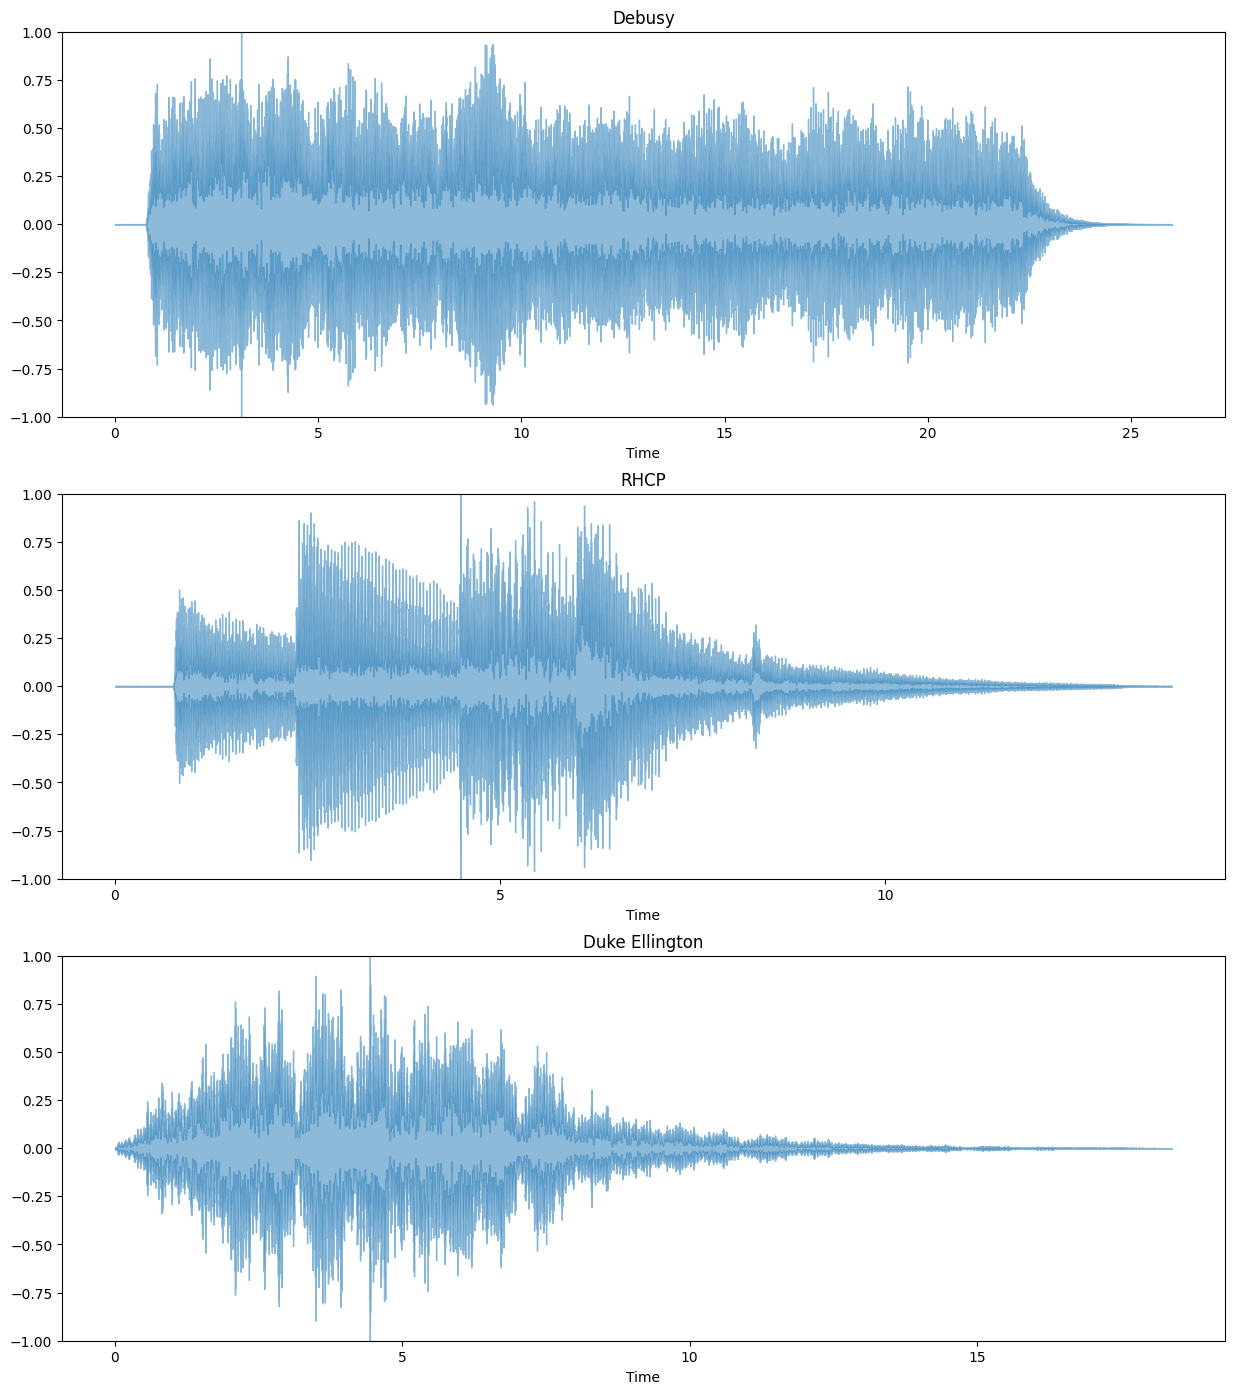

In [20]:
plt.figure(figsize=(15, 17))

plt.subplot(3, 1, 1)
librosa.display.waveshow(debussy, alpha=0.5)
plt.ylim((-1, 1))
plt.title("Debusy")

plt.subplot(3, 1, 2)
librosa.display.waveshow(redhot, alpha=0.5)
plt.ylim((-1, 1))
plt.title("RHCP")

plt.subplot(3, 1, 3)
librosa.display.waveshow(duke, alpha=0.5)
plt.ylim((-1, 1))
plt.title("Duke Ellington")

plt.show()

## Calculating amplitude envelope

In [21]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

def amplitude_envelope(signal, frame_size, hop_length):
    """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
    amplitude_envelope = []
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length): 
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)    

In [22]:
def fancy_amplitude_envelope(signal, frame_size, hop_length):
    """Fancier Python code to calculate the amplitude envelope of a signal with a given frame size."""
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])

In [23]:
# number of frames in amplitude envelope
ae_debussy = amplitude_envelope(debussy, FRAME_SIZE, HOP_LENGTH)
len(ae_debussy)

1120

In [24]:
# calculate amplitude envelope for RHCP and Duke Ellington
ae_redhot = amplitude_envelope(redhot, FRAME_SIZE, HOP_LENGTH)
ae_duke = amplitude_envelope(duke, FRAME_SIZE, HOP_LENGTH)

## Visualising amplitude envelope

In [25]:
frames = range(len(ae_debussy))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

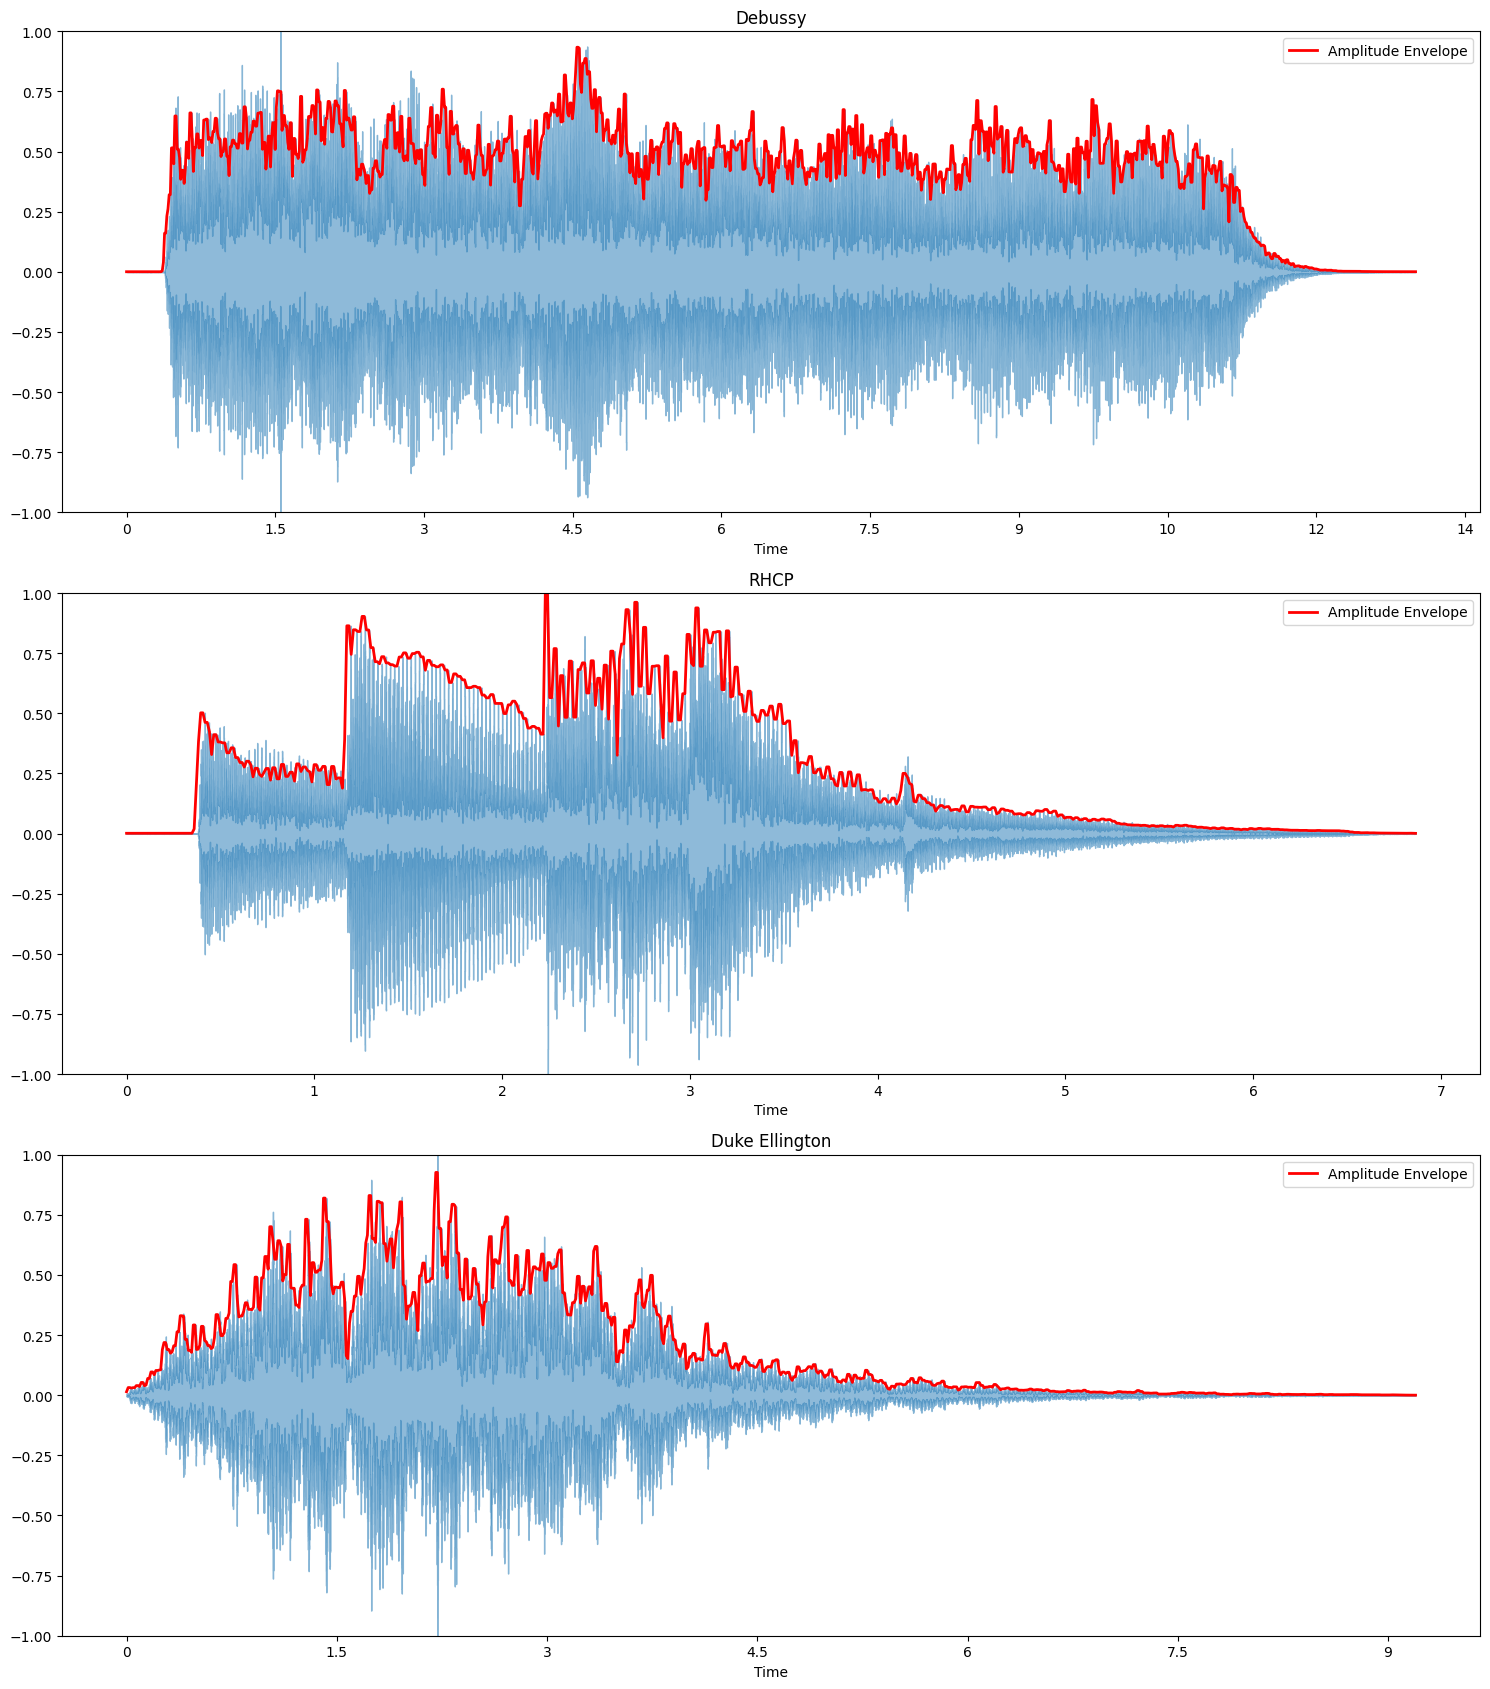

In [ ]:
# amplitude envelope is graphed in red

plt.figure(figsize=(15, 17))

# Create time arrays for each audio file
t_debussy = np.linspace(0, len(debussy) / sr, len(ae_debussy))
t_redhot = np.linspace(0, len(redhot) / sr, len(ae_redhot))
t_duke = np.linspace(0, len(duke) / sr, len(ae_duke))

ax = plt.subplot(3, 1, 1)
librosa.display.waveshow(debussy, sr=sr, alpha=0.5)
plt.plot(t_debussy, ae_debussy, color="r", linewidth=2, label="Amplitude Envelope")
plt.ylim((-1, 1))
plt.title("Debussy")
plt.legend()
#How both plots are linked together here?
#The magic is that matplotlib keeps drawing on the same axes until you create a new subplot or figure. That's how the waveform and envelope appear together!

plt.subplot(3, 1, 2)
librosa.display.waveshow(redhot, sr=sr, alpha=0.5)
plt.plot(t_redhot, ae_redhot, color="r", linewidth=2, label="Amplitude Envelope")
plt.ylim((-1, 1))
plt.title("RHCP")
plt.legend()

plt.subplot(3, 1, 3)
librosa.display.waveshow(duke, sr=sr, alpha=0.5)
plt.plot(t_duke, ae_duke, color="r", linewidth=2, label="Amplitude Envelope")
plt.ylim((-1, 1))
plt.title("Duke Ellington")
plt.legend()

plt.tight_layout()
plt.show()